In [1]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


### Load and explore the dataset.

In [2]:
train_df = pd.read_csv("/content/train.csv")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Dataset shape: (159571, 9)
Missing values:
 id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
label_sum        0
dtype: int64


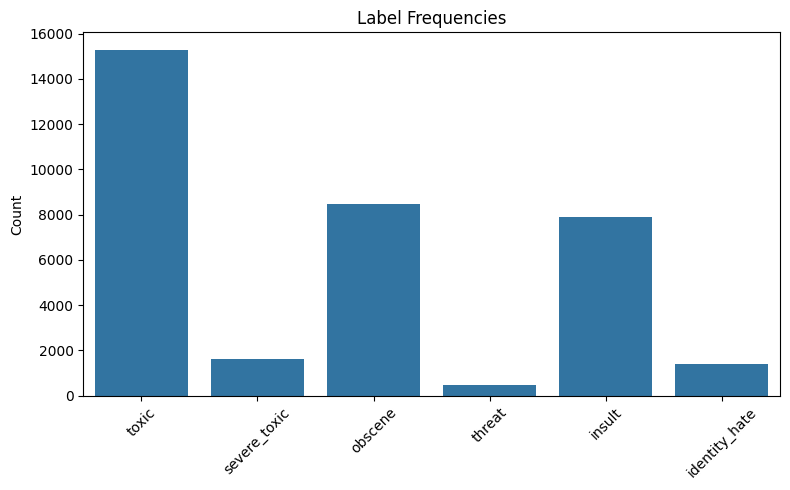

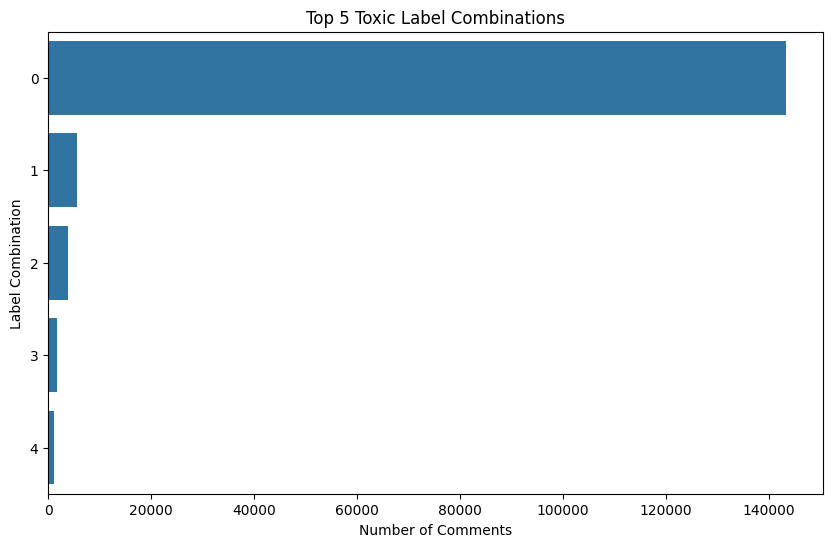

In [3]:
# 🧹 Basic cleanup
train_df['comment_text'] = train_df['comment_text'].fillna('').astype(str)

# 🏷️ Label summary
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df['label_sum'] = train_df[label_cols].sum(axis=1)  # Count of active labels per comment

# 🔍 Quick stats
print("Dataset shape:", train_df.shape)
print("Missing values:\n", train_df.isnull().sum())
#print("Label distribution:\n", train_df[label_cols].sum())

# 📊 Label distribution plot
plt.figure(figsize=(8, 5))
sns.barplot(x=label_cols, y=train_df[label_cols].sum().values)
plt.title('Label Frequencies')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📊 Most common label combos with counts
combo_counts = train_df[label_cols].value_counts().reset_index(name='count')
#print(combo_counts.head())

# Or plot it
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y=combo_counts.index[:5], orient='h', data=combo_counts.head())
plt.title("Top 5 Toxic Label Combinations")
plt.xlabel("Number of Comments")
plt.ylabel("Label Combination")
plt.show()

### Perform text preprocessing (cleaning, tokenization, stopword removal, vectorization)

In [4]:
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
def clean_text(text):
    # Convert to string
    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespaces
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return " ".join(tokens)
    return text

In [6]:
train_df['clean_comment_text'] = train_df['comment_text'].apply(clean_text)
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,clean_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww matches background colour im seemingly st...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,cant make real suggestions improvement wondere...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page thats
...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0,second time asking view completely contradicts...
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0,ashamed horrible thing put talk page
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0,spitzer umm theres actual article prostitution...
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0,looks like actually put speedy first version d...


In [7]:
# Tokenize the text
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_comment_text'])

# Convert to sequences
X_seq = tokenizer.texts_to_sequences(train_df['clean_comment_text'])

# Pad sequences
X_padded = pad_sequences(X_seq, maxlen=120, padding='post')

# Labels
y = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Save the tokenizer
import pickle
with open("reports/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print(f"📊 Vocab size (excluding reserved): {len(tokenizer.word_index)}")
import numpy as np
print("📐 Median sequence length:", np.median([len(seq) for seq in X_seq]))

📊 Vocab size (excluding reserved): 225522
📐 Median sequence length: 18.0


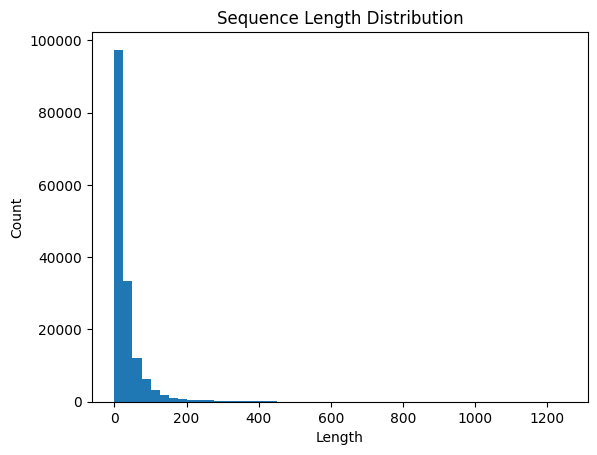

In [8]:
import matplotlib.pyplot as plt
plt.hist([len(seq) for seq in X_seq], bins=50)
plt.title("Sequence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

In [9]:
import numpy as np
lengths = [len(seq) for seq in X_seq]
coverage = np.percentile(lengths, [90, 95, 99])
print("📐 90th, 95th, 99th percentile lengths:", coverage)

📐 90th, 95th, 99th percentile lengths: [ 77. 116. 297.]


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ✅ Define the vectorizer
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')

# ✅ Fit-transform the text data
X_tfidf = tfidf.fit_transform(train_df['clean_comment_text'])

# ✅ Print output and sample vocabulary
print("✅ TF-IDF shape:", X_tfidf.shape)
print("📌 Sample vocab:", tfidf.get_feature_names_out()[:10])

✅ TF-IDF shape: (159571, 10000)
📌 Sample vocab: ['aa' 'aaron' 'ab' 'abandon' 'abandoned' 'abbey' 'abbreviation'
 'abbreviations' 'abc' 'abdul']


In [ ]:
#creating word cloud
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [ ]:
spam_wc = wc.generate(train_df[(train_df['label_sum'] >= 1)]['clean_comment_text'].str.cat(sep=" "))

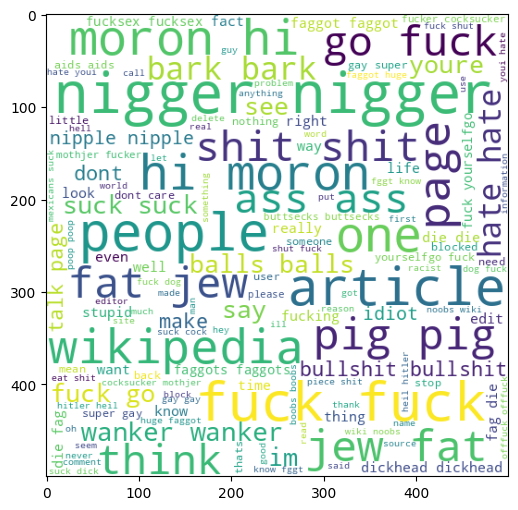

In [ ]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

###	Train a deep learning model for toxicity detection

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [12]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(127656, 120)
(31915, 120)
(127656, 6)
(31915, 6)


In [13]:
from keras.callbacks import EarlyStopping, Callback
import json

# Custom callback to log epoch-wise summary
class SummaryLogger(Callback):
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.epoch_summaries = []

    def on_epoch_end(self, epoch, logs=None):
        summary = {
            "epoch": epoch + 1,
            "loss": logs.get("loss"),
            "val_loss": logs.get("val_loss"),
            "accuracy": logs.get("accuracy"),
            "val_accuracy": logs.get("val_accuracy")
        }
        self.epoch_summaries.append(summary)

    def on_train_end(self, logs=None):
        with open(f"reports/{self.name}_summary.json", "w") as f:
            json.dump(self.epoch_summaries, f, indent=2)

# Common early stop callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

### LSTM Model:

In [14]:
from sklearn.utils.class_weight import compute_class_weight

def build_lstm_model(input_len, vocab_size):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_len),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(6, activation='sigmoid')  # multilabel
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model(input_len=120, vocab_size=20000)
lstm_callbacks = [early_stop, SummaryLogger("lstm")]


history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128,
    callbacks=lstm_callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 527s 522ms/step - accuracy: 0.8568 - loss: 0.1229 - val_accuracy: 0.9941 - val_loss: 0.0525
Epoch 2/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 529s 530ms/step - accuracy: 0.9905 - loss: 0.0483 - val_accuracy: 0.9941 - val_loss: 0.0502
Epoch 3/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 560s 528ms/step - accuracy: 0.9909 - loss: 0.0422 - val_accuracy: 0.9941 - val_loss: 0.0504
Epoch 4/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 562s 528ms/step - accuracy: 0.9852 - loss: 0.0377 - val_accuracy: 0.9941 - val_loss: 0.0528


In [15]:
# LSTM
lstm_model.save("models/lstm_model.h5")

### CNN Model:

In [16]:
from keras.layers import Conv1D, GlobalMaxPooling1D

def build_cnn_model(input_len, vocab_size):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_len),
        Conv1D(128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(6, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model(input_len=120, vocab_size=20000)
cnn_callbacks = [early_stop, SummaryLogger("cnn")]

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128,
    callbacks=cnn_callbacks
)

Epoch 1/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 229s 227ms/step - accuracy: 0.7140 - loss: 0.1261 - val_accuracy: 0.9941 - val_loss: 0.0527
Epoch 2/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 270s 235ms/step - accuracy: 0.9794 - loss: 0.0495 - val_accuracy: 0.9941 - val_loss: 0.0521
Epoch 3/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 254s 227ms/step - accuracy: 0.9719 - loss: 0.0421 - val_accuracy: 0.9941 - val_loss: 0.0543
Epoch 4/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 270s 235ms/step - accuracy: 0.9122 - loss: 0.0346 - val_accuracy: 0.9653 - val_loss: 0.0560


In [17]:
# CNN
cnn_model.save("models/cnn_model.h5")

In [18]:
import json

# 👇 Utility function to serialize Keras history
def serialize_history(history):
    return {key: [float(val) for val in values] for key, values in history.history.items()}

# 🔁 Gather model histories
training_results = {
    "lstm": serialize_history(history_lstm),
    "cnn": serialize_history(history_cnn)
}

# 💾 Save to single JSON file
with open("reports/model_training_results.json", "w") as f:
    json.dump(training_results, f, indent=2)

print("✅ All model histories saved to 'reports/model_training_results.json'")

✅ All model histories saved to 'reports/model_training_results.json'


### Model Evaluation & Comparison

In [19]:
import matplotlib.pyplot as plt
import json

# Load training results from JSON
with open("reports/model_training_results.json", "r") as f:
    results = json.load(f)

lstm = results["lstm"]
cnn = results["cnn"]

epochs_lstm = range(1, len(lstm["accuracy"]) + 1)
epochs_cnn = range(1, len(cnn["accuracy"]) + 1)

plt.figure(figsize=(14, 6))

# 🎯 Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_lstm, lstm["accuracy"], 'b-', label='LSTM Train Acc')
plt.plot(epochs_lstm, lstm["val_accuracy"], 'b--', label='LSTM Val Acc')
plt.plot(epochs_cnn, cnn["accuracy"], 'g-', label='CNN Train Acc')
plt.plot(epochs_cnn, cnn["val_accuracy"], 'g--', label='CNN Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# 📉 Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_lstm, lstm["loss"], 'r-', label='LSTM Train Loss')
plt.plot(epochs_lstm, lstm["val_loss"], 'r--', label='LSTM Val Loss')
plt.plot(epochs_cnn, cnn["loss"], 'm-', label='CNN Train Loss')
plt.plot(epochs_cnn, cnn["val_loss"], 'm--', label='CNN Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("reports/training_history.png")
plt.close()

In [20]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
class_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

def evaluate_and_save(model, X_val, y_val, class_names, model_name, threshold=0.5):
    # Step 1: Predict probabilities
    y_prob = model.predict(X_val)
    y_pred = (y_prob >= threshold).astype(int)

    # Step 2: Save classification report
    report = classification_report(y_val, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f"reports/{model_name}_classification_report.csv")

    # Optional: Console summary
    print(f"\n📊 {model_name} Classification Report")
    print(df_report[['precision', 'recall', 'f1-score']].round(3))

In [21]:
from tensorflow.keras.models import load_model

lstm_model = load_model("models/lstm_model.h5")
cnn_model = load_model("models/cnn_model.h5")

evaluate_and_save(lstm_model, X_val, y_val, class_names, "LSTM")
evaluate_and_save(cnn_model,  X_val, y_val, class_names, "CNN")

998/998 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step

📊 LSTM Classification Report
               precision  recall  f1-score
toxic              0.838   0.746     0.790
severe_toxic       0.673   0.115     0.197
obscene            0.829   0.773     0.800
threat             0.000   0.000     0.000
insult             0.709   0.678     0.693
identity_hate      0.000   0.000     0.000
micro avg          0.800   0.670     0.729
macro avg          0.508   0.385     0.413
weighted avg       0.755   0.670     0.702
samples avg        0.065   0.061     0.060
  1/998 ━━━━━━━━━━━━━━━━━━━━ 1:34 95ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

998/998 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step

📊 CNN Classification Report
               precision  recall  f1-score
toxic              0.839   0.711     0.770
severe_toxic       0.686   0.075     0.135
obscene            0.816   0.783     0.799
threat             0.000   0.000     0.000
insult             0.696   0.681     0.688
identity_hate      0.000   0.000     0.000
micro avg          0.793   0.656     0.718
macro avg          0.506   0.375     0.399
weighted avg       0.750   0.656     0.690
samples avg        0.061   0.059     0.058


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

### Deployment

In [22]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.7 MB/s eta 0:00:00


In [23]:
!pip install pyngrok

In [24]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
added 22 packages in 3s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸

In [40]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import re
import string
import pickle
import json
import nltk
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# ------------------ Text Cleaning ------------------ #
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

# ------------------ Load Models ------------------ #
@st.cache_resource
def load_models_and_tokenizer():
    lstm = load_model("models/lstm_model.h5")
    cnn = load_model("models/cnn_model.h5")
    with open("reports/tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    return lstm, cnn, tokenizer

lstm_model, cnn_model, tokenizer = load_models_and_tokenizer()

# ------------------ BEST Models ------------------ #
import shutil

@st.cache_data
def store_best_model(training_results):
    lstm_val_acc = training_results["lstm"]["val_accuracy"][-1]
    cnn_val_acc = training_results["cnn"]["val_accuracy"][-1]

    best_model_name = "lstm" if lstm_val_acc > cnn_val_acc else "cnn"
    model_file = f"models/{best_model_name}_model.h5"
    target_file = f"models/best_model.h5"

    os.makedirs("best_model", exist_ok=True)
    shutil.copy(model_file, target_file)

    return best_model_name, lstm_val_acc, cnn_val_acc

# ------------------ Evaluate Models ------------------ #
@st.cache_data
def evaluate_model_from_json():
    with open("reports/model_training_results.json", "r") as f:
        results = json.load(f)
    return results

training_results = evaluate_model_from_json()

@st.cache_data
def load_classification_report(path):
    df = pd.read_csv(path, index_col=0)
    df = df.dropna(how="all", axis=1)  # Clean up trailing columns if needed
    return df.round(4)

summary_df = pd.DataFrame({
'Model': [m.upper() for m in training_results.keys()],
'Final Val Accuracy': [round(training_results[m]['val_accuracy'][-1], 4) for m in training_results],
'Final Val Loss': [round(training_results[m]['val_loss'][-1], 4) for m in training_results]
})

#best_model_name = summary_df.loc[summary_df['Final Val Accuracy'].idxmax(), 'Model']
#best_model = lstm_model if best_model_name == "LSTM" else cnn_model
best_model_name = "CNN"
best_model = cnn_model

# ------------------ Streamlit App ------------------ #
st.set_page_config(page_title="Comment Toxicity Detection")
st.title("🧠 Comment Toxicity Detection")
st.write("A real-time interactive toxicity detection web application that enhances online content moderation")

page = st.sidebar.radio("Navigation", ["📊 Model Comparison", "💬 Single Comment", "📁 Bulk Predictions"])

if page == "📊 Model Comparison":
    st.subheader("📊 Model Training Performance")

    lstm_epochs = len(training_results["lstm"]["accuracy"])
    cnn_epochs = len(training_results["cnn"]["accuracy"])

    acc_df = pd.DataFrame({
        "Epoch": list(range(1, lstm_epochs + 1)) * 2 + list(range(1, cnn_epochs + 1)) * 2,
        "Accuracy": training_results["lstm"]["accuracy"] +
                    training_results["lstm"]["val_accuracy"] +
                    training_results["cnn"]["accuracy"] +
                    training_results["cnn"]["val_accuracy"],
        "Set": (["LSTM Train"] * lstm_epochs +
                ["LSTM Val"] * lstm_epochs +
                ["CNN Train"] * cnn_epochs +
                ["CNN Val"] * cnn_epochs)
    })

    loss_df = pd.DataFrame({
        "Epoch": list(range(1, lstm_epochs + 1)) * 2 + list(range(1, cnn_epochs + 1)) * 2,
        "Loss": training_results["lstm"]["loss"] +
                training_results["lstm"]["val_loss"] +
                training_results["cnn"]["loss"] +
                training_results["cnn"]["val_loss"],
        "Set": (["LSTM Train"] * lstm_epochs +
                ["LSTM Val"] * lstm_epochs +
                ["CNN Train"] * cnn_epochs +
                ["CNN Val"] * cnn_epochs)
    })

    col1, col2 = st.columns(2)
    with col1:
        acc_fig = px.line(acc_df, x="Epoch", y="Accuracy", color="Set", markers=True,
                          title="Accuracy")
        st.plotly_chart(acc_fig, use_container_width=True)

    with col2:
        loss_fig = px.line(loss_df, x="Epoch", y="Loss", color="Set", markers=True,
                           title="Loss")
        st.plotly_chart(loss_fig, use_container_width=True)


    # ------------------ Classification Report Bar Charts ------------------ #
    st.markdown("### 📊 Classification Report")

    # Load classification reports
    cnn_report = load_classification_report("reports/CNN_classification_report.csv")
    lstm_report = load_classification_report("reports/LSTM_classification_report.csv")

    def plot_classification_metrics(df, title, color):
        df_viz = df.loc[labels][["precision", "recall", "f1-score"]]
        df_viz = df_viz.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score")
        fig = px.bar(
            df_viz,
            x="index",
            y="Score",
            color="Metric",
            barmode="group",
            title=title,
            text_auto=".2f",
            color_discrete_sequence=color
        )
        fig.update_layout(xaxis_title="Labels", yaxis_title="Score")
        return fig
    tab1, tab2 = st.tabs([ "CNN","LSTM"])
    with tab1:
      cnn_fig = plot_classification_metrics(cnn_report, "CNN: Precision, Recall, F1-score", ["#1f77b4", "#ff7f0e", "#2ca02c"])
      st.plotly_chart(cnn_fig, use_container_width=True)
    with tab2:
      try:
          lstm_fig = plot_classification_metrics(lstm_report, "LSTM: Precision, Recall, F1-score", ["#9467bd", "#8c564b", "#e377c2"])
          st.plotly_chart(lstm_fig, use_container_width=True)
      except:
          st.info("LSTM classification report not found. Upload `LSTM_classification_report.csv` to see visualized metrics.")

# ------------------ Page 2: Single Comment ------------------ #
elif page == "💬 Single Comment":
    st.subheader("💬 Classify a Single Comment")
    comment = st.text_area("Enter your comment")
    classify_btn = st.button("Classify")

    if classify_btn:
        if not comment.strip():
            st.warning("Please enter a valid comment.")
        else:
            cleaned = clean_text(comment)
            if not cleaned:
                st.warning("Input became empty after cleaning. Try a different comment.")
            else:
                seq = tokenizer.texts_to_sequences([cleaned])
                padded = pad_sequences(seq, maxlen=200)
                pred = best_model.predict(padded)[0]

                #st.info(f"Using best model: **{best_model_name}**")
                st.subheader("🔍 Prediction")
                for label, score in zip(labels, pred):
                    st.write(f"**{label}**: {score:.2f}")

# ------------------ Page 3: Bulk Prediction ------------------ #
elif page == "📁 Bulk Predictions":
    st.subheader("📁 Predict Toxicity for Uploaded CSV")
    st.write("Upload a CSV file with `id` and `comment_text` columns.")

    uploaded = st.file_uploader("Upload CSV", type=["csv"])

    if uploaded:
        try:
            df = pd.read_csv(uploaded)
            if 'id' not in df.columns or 'comment_text' not in df.columns:
                st.error("CSV must have 'id' and 'comment_text' columns.")
            else:
                df['cleaned'] = df['comment_text'].astype(str).apply(clean_text)
                seqs = tokenizer.texts_to_sequences(df['cleaned'])
                padded = pad_sequences(seqs, maxlen=200)

                #st.info(f"Using best model: **{best_model_name}**")
                preds = best_model.predict(padded)
                pred_df = pd.DataFrame(preds, columns=labels)
                result = pd.concat([df[['id', 'comment_text']], pred_df], axis=1)

                st.dataframe(result.head())
                csv = result.to_csv(index=False).encode("utf-8")
                st.download_button("📥 Download Predictions", csv, file_name="predicted_toxic_comments.csv")

        except Exception as e:
            st.error(f"❌ Error: {e}")

Overwriting app.py


In [41]:
!streamlit run /content/app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.23.18.171
⠙⠹your url is: https://moody-meals-swim.loca.lt
